In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def yoon_kim_conv_layer(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)
    
    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([block_1_max_pool1, block_1_max_pool2, block_1_max_pool3, block_1_max_pool4])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [9]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 256

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Add()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = yoon_kim_conv_layer(filtersNumber, embedding_dropout)
features_2 = yoon_kim_conv_layer(filtersNumber, embedding_dropout)
features_3 = yoon_kim_conv_layer(filtersNumber, embedding_dropout)

features = concatenate([features_1, features_2, features_3])
features_dropout = Dropout(0.2)(features)

dense_1 = Dense(256, activation = 'elu')(features_dropout)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [10]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42880/102124 [===========>..................] - ETA: 5:00 - loss: 0.1615 - acc: 0.9382

102124/102124 [==============================] - 559s 5ms/step - loss: 0.1023 - acc: 0.9619 - val_loss: 0.0468 - val_acc: 0.9827
Epoch 2/32
  5440/102124 [>.............................] - ETA: 7:59 - loss: 0.0534 - acc: 0.9809

102080/102124 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9804

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0532 - acc: 0.9804 - val_loss: 0.0426 - val_acc: 0.9841
roc-auc: 0.9877 - roc-auc_val: 0.984                                                                                                    
Epoch 3/32
 17472/102124 [====>.........................] - ETA: 7:00 - loss: 0.0480 - acc: 0.9822

102080/102124 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9817

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0483 - acc: 0.9817 - val_loss: 0.0442 - val_acc: 0.9832
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 6:46 - loss: 0.0453 - acc: 0.9825

102080/102124 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9825

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0453 - acc: 0.9825 - val_loss: 0.0427 - val_acc: 0.9838

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00036602141335606575.
roc-auc: 0.9897 - roc-auc_val: 0.9863                                                                                                    
Epoch 5/32
 11840/102124 [==>...........................] - ETA: 7:28 - loss: 0.0442 - acc: 0.9826

102080/102124 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9834

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0426 - acc: 0.9834 - val_loss: 0.0426 - val_acc: 0.9844
Epoch 6/32
 20352/102124 [====>.........................] - ETA: 6:47 - loss: 0.0388 - acc: 0.9845

102080/102124 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9844

102124/102124 [==============================] - 556s 5ms/step - loss: 0.0399 - acc: 0.9844 - val_loss: 0.0422 - val_acc: 0.9839
roc-auc: 0.9933 - roc-auc_val: 0.985                                                                                                    
Epoch 7/32
 17472/102124 [====>.........................] - ETA: 7:00 - loss: 0.0375 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9850

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0379 - acc: 0.9850 - val_loss: 0.0415 - val_acc: 0.9847
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 6:47 - loss: 0.0350 - acc: 0.9858

102080/102124 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9855

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0358 - acc: 0.9855 - val_loss: 0.0422 - val_acc: 0.9845
roc-auc: 0.9923 - roc-auc_val: 0.9864                                                                                                    
Epoch 9/32
 17408/102124 [====>.........................] - ETA: 7:01 - loss: 0.0340 - acc: 0.9867

102080/102124 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9864

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0339 - acc: 0.9865 - val_loss: 0.0457 - val_acc: 0.9844
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 6:47 - loss: 0.0316 - acc: 0.9870

102080/102124 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9870

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0319 - acc: 0.9870 - val_loss: 0.0433 - val_acc: 0.9845
roc-auc: 0.9971 - roc-auc_val: 0.9877                                                                                                    
Epoch 11/32
 17344/102124 [====>.........................] - ETA: 7:00 - loss: 0.0314 - acc: 0.9873

102080/102124 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9877

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0308 - acc: 0.9877 - val_loss: 0.0448 - val_acc: 0.9843
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 6:47 - loss: 0.0294 - acc: 0.9878

102080/102124 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9882

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0289 - acc: 0.9882 - val_loss: 0.0460 - val_acc: 0.9841
roc-auc: 0.996 - roc-auc_val: 0.9867                                                                                                    
Epoch 13/32
 17408/102124 [====>.........................] - ETA: 6:57 - loss: 0.0270 - acc: 0.9888

102080/102124 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9888

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0276 - acc: 0.9888 - val_loss: 0.0485 - val_acc: 0.9841
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 6:44 - loss: 0.0262 - acc: 0.9893

102080/102124 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9892

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0267 - acc: 0.9892 - val_loss: 0.0479 - val_acc: 0.9840
roc-auc: 0.995 - roc-auc_val: 0.9846                                                                                                    
Epoch 15/32
 17408/102124 [====>.........................] - ETA: 7:01 - loss: 0.0247 - acc: 0.9901

102080/102124 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9898

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0254 - acc: 0.9898 - val_loss: 0.0491 - val_acc: 0.9842

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001166291258414276.
Epoch 16/32
 16064/102124 [===>..........................] - ETA: 7:07 - loss: 0.0248 - acc: 0.9900

102080/102124 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9900

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0247 - acc: 0.9900 - val_loss: 0.0488 - val_acc: 0.9838
roc-auc: 0.9967 - roc-auc_val: 0.9869                                                                                                    
Epoch 17/32
 17344/102124 [====>.........................] - ETA: 7:01 - loss: 0.0231 - acc: 0.9906

102080/102124 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9905

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0235 - acc: 0.9905 - val_loss: 0.0500 - val_acc: 0.9841


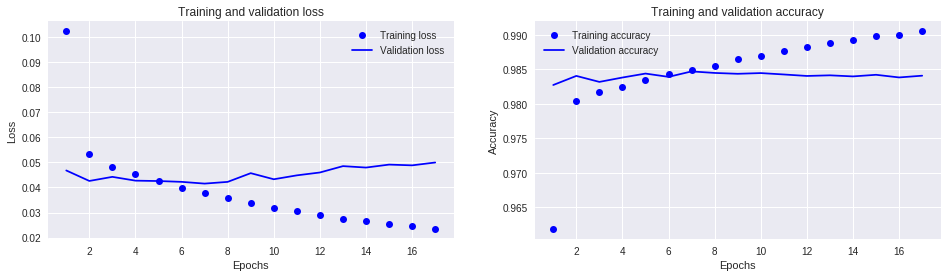

In [11]:
plot_history(history)

In [12]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 67s 2ms/step
([0.04754464275685648, 0.9844378155917186], 0.9874536251966425)
